In [1]:
setwd("E:/notebook/childhood_pneumonia")
library(xgboost)
library(Matrix)
library(verification)
library(pROC)
library(ggplot2)
library(ggpubr)
library(caret)
library(DiagrammeR)
library(tidyverse)
library(pacman)

Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following object is masked from 'package:Matrix':

    det


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: boot

Loading required package: CircStats

Loading required package: MASS

Loading required package: dtw

Loading required package: proxy


Attaching package: 'proxy'


The following object is masked from 'package:spam':

    as.matrix


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats

In [2]:
data <- read.csv("./Results/2.model_data.csv",stringsAsFactors = F)
dead <- data[which(data$survival  == 1),]
alive <- data[which(data$survival  == 0),]

## split train & test

In [3]:
set.seed(1)
dead_random <-sample(1:95,76)
alive_random <-sample(1:536,429)

train <- rbind(dead[dead_random,],alive[alive_random,])
test <- rbind(dead[-dead_random,],alive[-alive_random,])

In [4]:
train_data <- as.matrix(train[,-(1:2)]) 
test_data <- as.matrix(test[,-(1:2)])## Xgboost training
train_label <- train$survival  ### sample clinical information
traindata1 <- data.matrix(train[,-(1:2)]) 
traindata2 <- Matrix(traindata1,sparse=T)  ## 
traindata3 <- factor(train_label,levels = c(0,1))   ### 
traindata4 <- list(data=traindata2,label=train_label)  ### candidate training data

dtrain <- xgb.DMatrix(data = traindata4$data, label = traindata4$label)

## best param

In [5]:
grd <- expand.grid(
  eta = seq(0.001, 0.2, length.out = 5),
  max_depth = seq(2L, 5L, by = 1),
  min_child_weight = seq(1, 25, length.out = 3),
  subsample = c(0.2,0.6,0.8),
  colsample_bytree=c(0.25, 0.5, 1))

dim(grd)

[1] 540   5

In [6]:
grd_out <- apply(grd, 1, function(par){
  
  par <- append(par, list(objective = "binary:logistic",eval_metric = "logloss"))
  mdl <- xgboost(data = dtrain, params = par, nrounds = 100, early_stopping_rounds = 5, maximize = F, verbose = 0)
  lst <- data.frame(par, score = mdl$best_score)
  
  return(lst)
})


In [7]:
grd_out <- do.call(rbind, grd_out)

best_par <- grd_out %>%
  data.frame() %>%
  arrange(score) %>%
  .[1,]
best_par

,eta,max_depth,min_child_weight,subsample,colsample_bytree,objective,eval_metric,score
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,0.2,5,1,0.8,1,binary:logistic,logloss,0.06350403


In [5]:
best_params<-as.list(c(eta=0.2,max_depth=5,min_child_weight=1,
                subsample=0.8,colsample_bytree=1,
                objective="binary:logistic",eval_metric="logloss"))

In [6]:
set.seed(978)
xgbcv <- xgb.cv(params = best_params,
                data = dtrain,
                nround = 100,
                nfold = 5,
                prediction = TRUE,
                early_stopping_rounds = 5,
                verbose = 0,
                maximize = F)

nround = xgbcv$best_iteration
nround

[1] 14

## Final model

In [7]:
#final model
set.seed(978)
mxgb5m <- xgboost(data = dtrain, 
               params = best_params, 
               maximize = F, 
               nrounds = nround,
               early_stopping_rounds = 5, 
               verbose = 0)

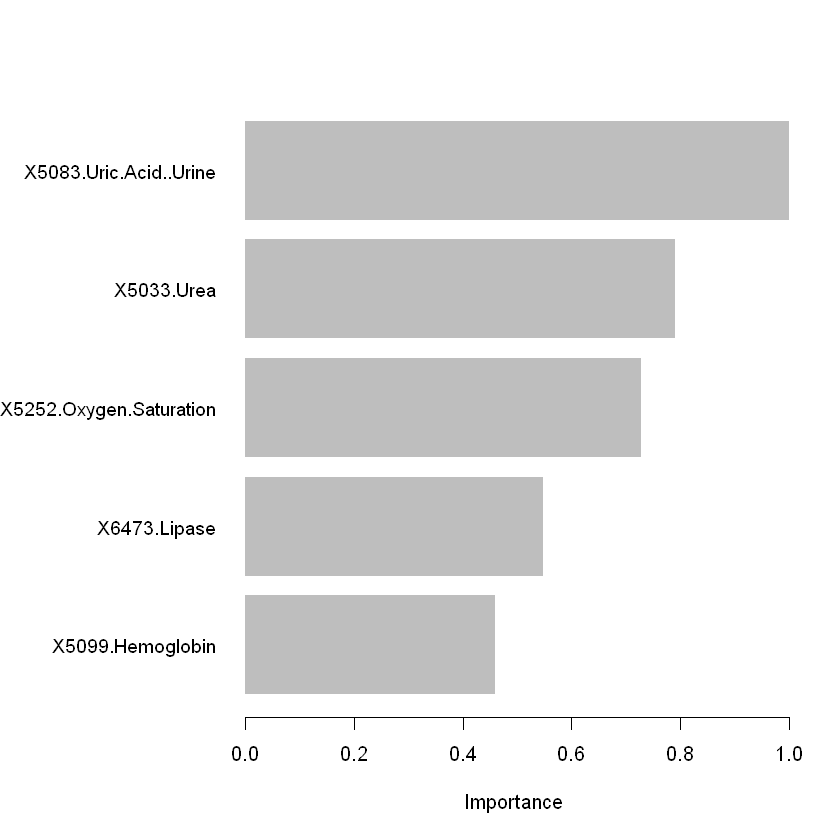

In [8]:
#importance
importance_matrix <- xgb.importance(colnames(dtrain), model = mxgb5m)
xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Importance")

In [9]:
train_pred <- predict(mxgb5m,train_data,type = "response")
roc(train_label,train_pred)
test_pred <- predict(mxgb5m,test_data,type = "response")
roc(test$survival,test_pred)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_label, predictor = train_pred)

Data: train_pred in 429 controls (train_label 0) < 76 cases (train_label 1).
Area under the curve: 0.9425

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test$survival, predictor = test_pred)

Data: test_pred in 107 controls (test$survival 0) < 19 cases (test$survival 1).
Area under the curve: 0.8763

Setting levels: control = 0, case = 1

Setting direction: controls < cases



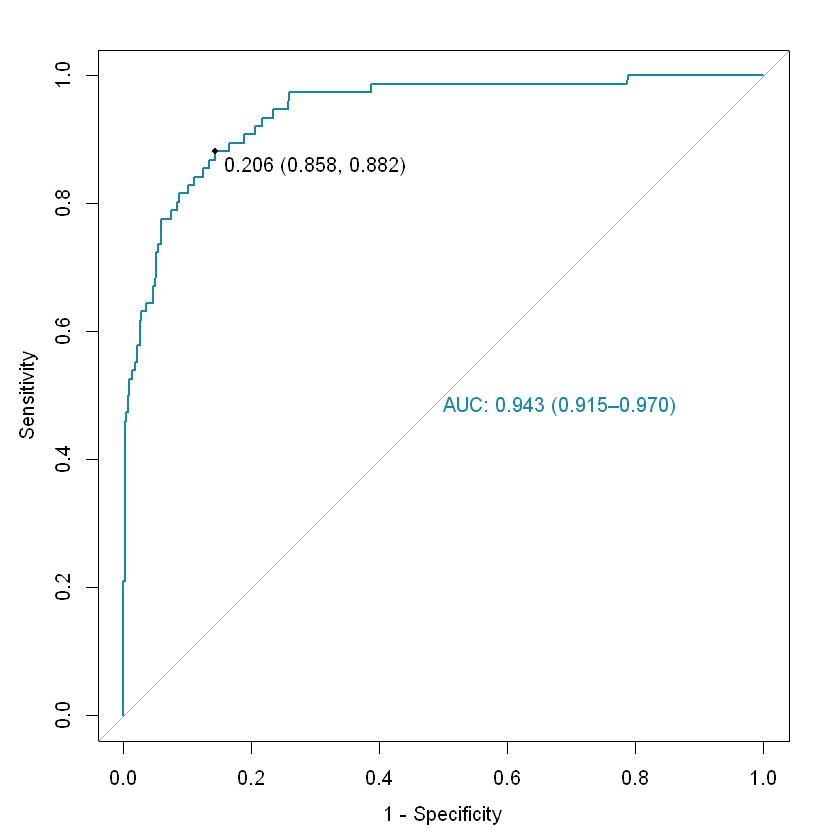

In [10]:
aa<-roc(train_label,train_pred, plot=TRUE, print.thres=TRUE, ci=TRUE,
        print.auc=TRUE,legacy.axes = TRUE,col = "#1687A7")#cutoff=0.206

Setting levels: control = 0, case = 1

Setting direction: controls < cases



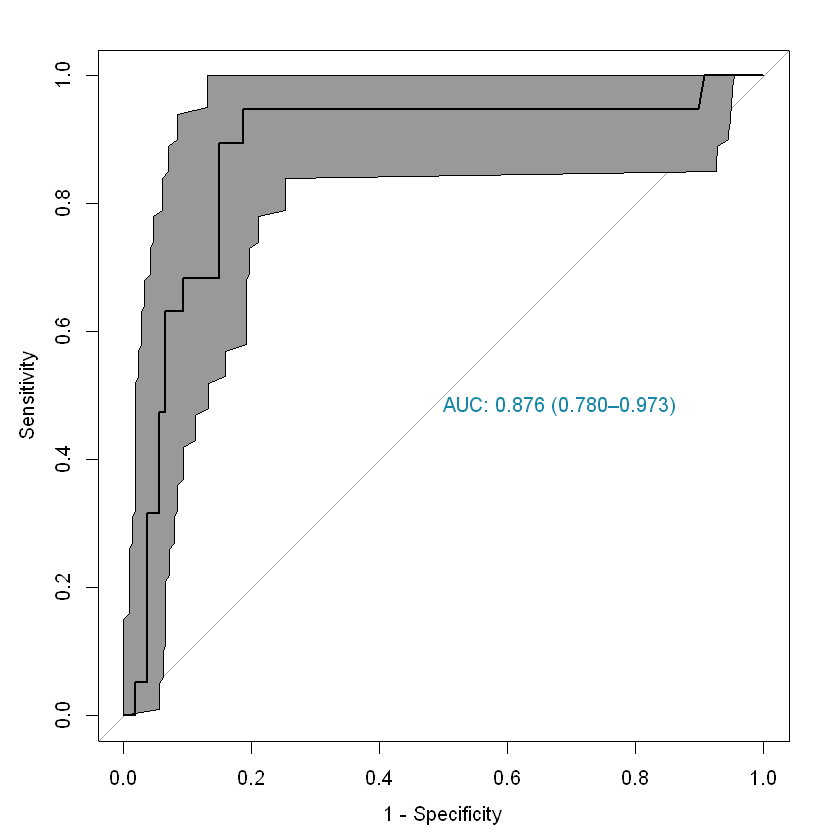

In [12]:
bb<-roc(test$survival,test_pred, plot=TRUE, print.thres=TRUE, ci=TRUE,
        print.auc=TRUE,legacy.axes = TRUE,col = "#1687A7")
sp.obj <- ci.sp(bb, sensitivities=seq(0, 1, .01), boot.n=100) 
plot(sp.obj, type="shape", col="gray60") 

## Train cohort

In [15]:
library(survival)
library(survminer)
library(pheatmap)
library(grid)
library(cowplot)


Attaching package: 'survival'


The following object is masked from 'package:caret':

    cluster


The following object is masked from 'package:boot':

    aml



Attaching package: 'survminer'


The following object is masked from 'package:survival':

    myeloma



Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




### KM

Call:
survdiff(formula = Surv(train$Time, train$survival) ~ train$fenzu, 
    data = train)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
train$fenzu=High 126       66     17.4     135.1       179
train$fenzu=Low  379       10     58.6      40.3       179

 Chisq= 179  on 1 degrees of freedom, p= <2e-16 

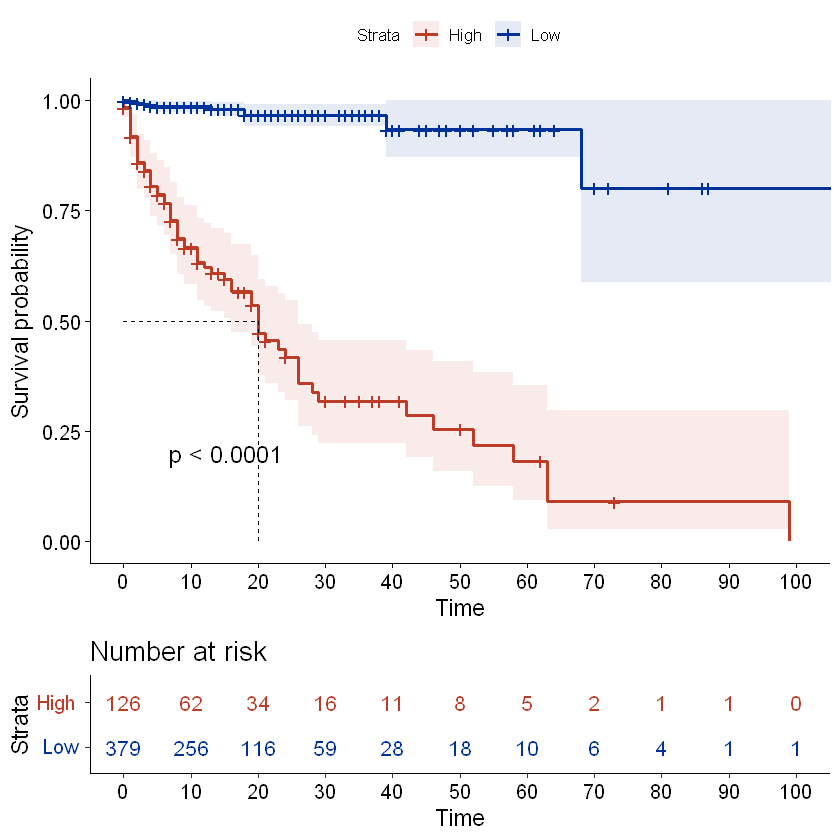

In [14]:
train$fenzu<-NA
train$fenzu[which(train_pred>0.206)]<-"High"
train$fenzu[which(train_pred<=0.206)]<-"Low"
blue <- "#003399"
red <- "#BC3C28"
train_surv <- survfit(Surv(train$Time,train$survival)~train$fenzu,data = train)
survdiff(Surv(train$Time,train$survival)~train$fenzu,data = train)
ggsurvplot(train_surv,
           pval = TRUE,#P-value
           risk.table = TRUE, # Add risk table
           risk.table.col = "strata", # Change risk table color by groups
           palette = c(red,blue),
           conf.int = T,
           conf.int.alpha=0.1, #CI
           surv.median.line = "hv", # median survival time
           xlim=c(0,100),
           break.x.by = 10,
           legend.labs=c("High","Low")
)

In [15]:
# HR
summary(coxph(Surv(train$Time,train$survival) ~ train_pred))  #

Call:
coxph(formula = Surv(train$Time, train$survival) ~ train_pred)

  n= 505, number of events= 76 

                coef exp(coef)  se(coef)     z Pr(>|z|)    
train_pred    8.3433 4202.0881    0.5495 15.18   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

           exp(coef) exp(-coef) lower .95 upper .95
train_pred      4202   0.000238      1431     12337

Concordance= 0.911  (se = 0.02 )
Likelihood ratio test= 181.4  on 1 df,   p=<2e-16
Wald test            = 230.5  on 1 df,   p=<2e-16
Score (logrank) test = 402.1  on 1 df,   p=<2e-16


### heatmap

    survival           Time          X5033.Urea     X5083.Uric.Acid..Urine
 Min.   :0.0000   Min.   :  0.00   Min.   : 0.450   Min.   :  57.0        
 1st Qu.:0.0000   1st Qu.:  6.00   1st Qu.: 2.295   1st Qu.: 169.4        
 Median :0.0000   Median : 12.00   Median : 3.330   Median : 239.0        
 Mean   :0.1505   Mean   : 17.24   Mean   : 3.882   Mean   : 275.9        
 3rd Qu.:0.0000   3rd Qu.: 22.00   3rd Qu.: 4.812   3rd Qu.: 343.5        
 Max.   :1.0000   Max.   :335.00   Max.   :20.320   Max.   :1129.9        
                                   NA's   :9        NA's   :10            
 X5099.Hemoglobin X5252.Oxygen.Saturation  X6473.Lipase      fenzu          
 Min.   : 13.0    Min.   : 19.00          Min.   : 0.00   Length:505        
 1st Qu.: 95.0    1st Qu.: 84.42          1st Qu.: 0.00   Class :character  
 Median :107.0    Median : 97.40          Median : 0.00   Mode  :character  
 Mean   :109.7    Mean   : 89.16          Mean   : 2.96                     
 3rd Qu.:120.0 

    fenzu              survival     
 Length:505         Min.   :0.0000  
 Class :character   1st Qu.:0.0000  
 Mode  :character   Median :0.0000  
                    Mean   :0.1505  
                    3rd Qu.:0.0000  
                    Max.   :1.0000  

   Risk     Survival
 High:126   0:429   
 Low :379   1: 76   

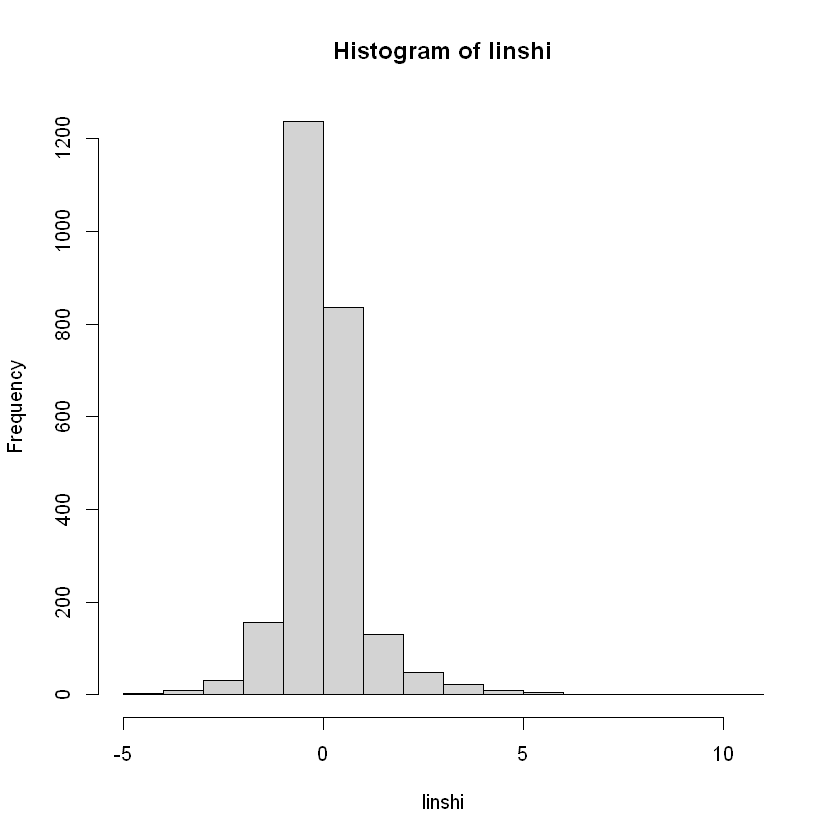

In [16]:
red <- rgb(255,0,0,maxColorValue = 255)
blue <- rgb(0,0,255,maxColorValue = 255)
white <- rgb(255,255,255,maxColorValue = 255)
summary(train)
train$score=train_pred
heat_cli=train[,c(8,1)]#risk and sur
heat_cli<-heat_cli[order(train$score),]
summary(heat_cli)
heat_exp=train[,c(3:7)]
heat_exp<-heat_exp[order(train$score),]
annotation_col = data.frame(Risk=as.factor(heat_cli[,1]),
                            Survival=as.factor(heat_cli[,2]))
summary(annotation_col)
rownames(annotation_col) <- rep(1:nrow(train))
ann_colors = list(Risk=c("Low"="#003399","High"="#BC3C28"),
                  Survival=c("0"="#2E94B9","1"="#de4307"))

linshi <- scale(heat_exp[,1:5])#归一化
rownames(linshi) <- rep(1:nrow(train))
linshi<-t(linshi)
hist(linshi)

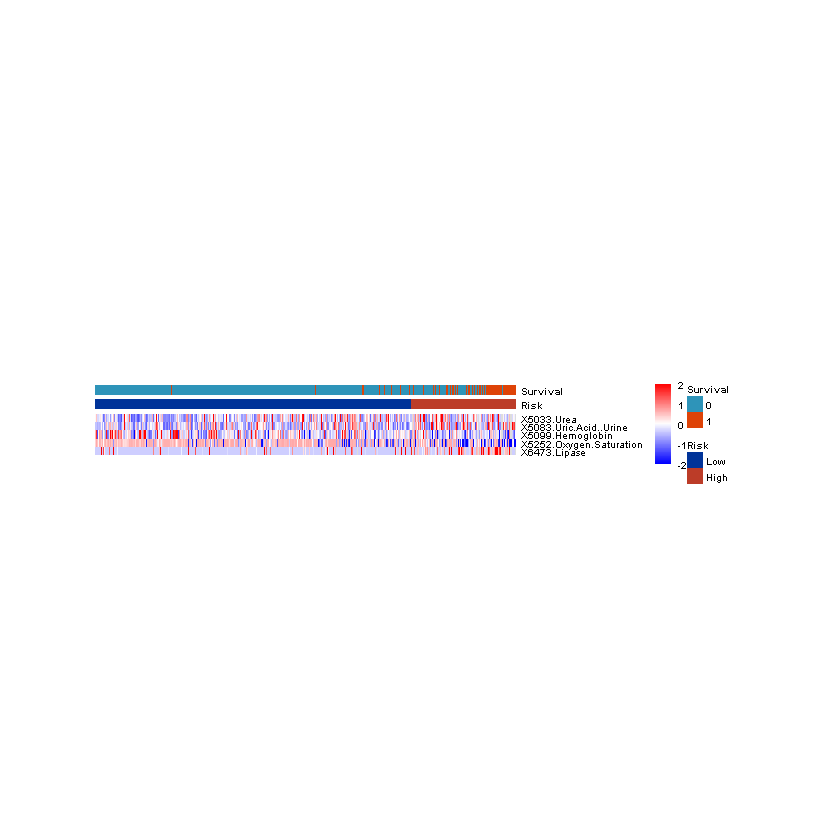

png 
  2

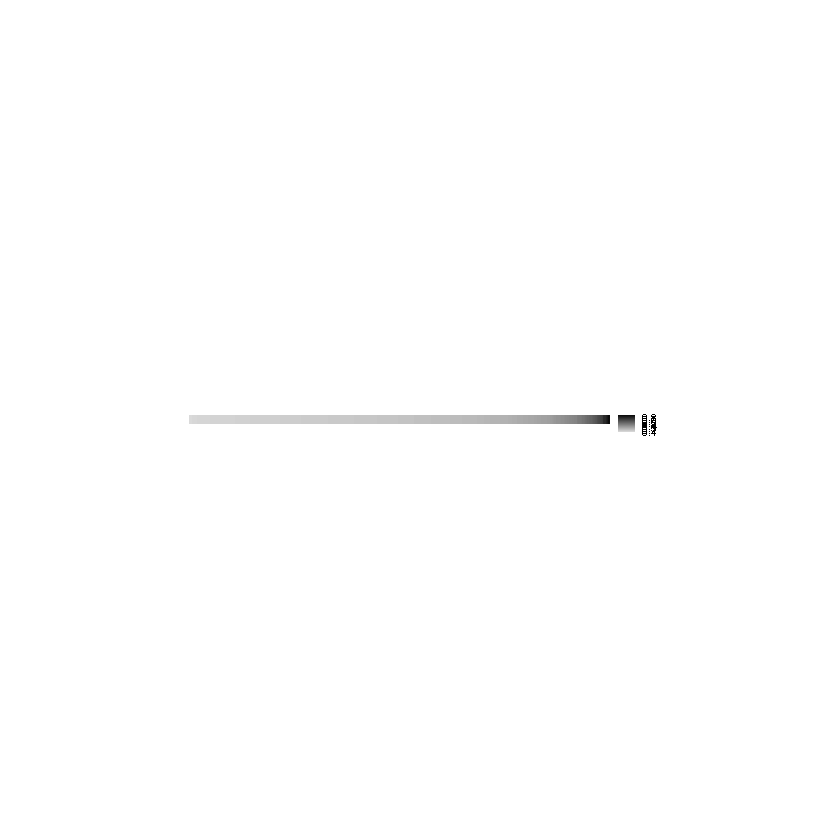

In [17]:
linshi[linshi>2] <- 2
linshi[linshi<(-2)] <- c(-2)
p1<-pheatmap(linshi,fontsize=6,cutree_col = 4,cellheight = 5,cellwidth = 0.5 ,
           color  = colorRampPalette(c(blue,white,red))(100),
           annotation_col = annotation_col,
           annotation_colors = ann_colors,
           clustering_method = "ward.D2",
           border_color = "grey60",
           cluster_cols = F, cluster_rows = F,
           show_rownames = T, show_colnames = F
    )
p1
score=train$score[order(train$score)]
score<-t(score)
p2<-pheatmap(score,fontsize=6,cutree_col = 4,cellheight = 5,cellwidth = 0.5 ,
           color  = colorRampPalette(c("#dadada","#0B0B0B"))(100),
           clustering_method = "ward.D2",
           border_color = "grey60",
           cluster_cols = F, cluster_rows = F,
           show_rownames = T, show_colnames = T
    )
p2
p_train <- plot_grid(p2$gtable,p1$gtable, nrow = 2, align = "v")
pdf("./Figs/3. heatmapTrain.pdf")
p_train
dev.off()

### boxplot: compare high and low group

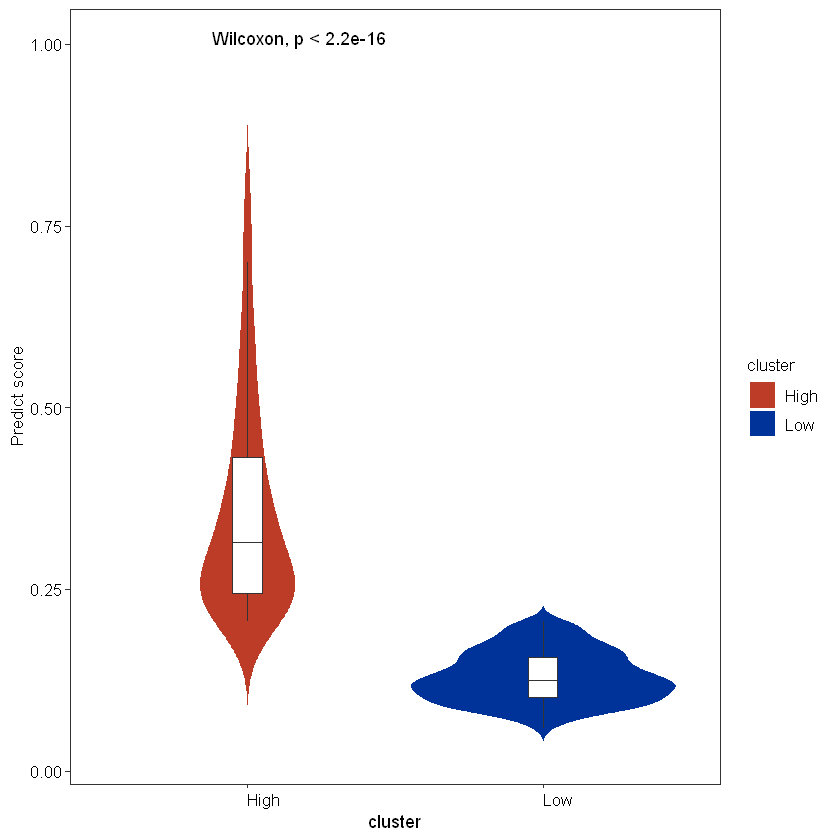

In [18]:
##all
data2 <- data.frame(score = train_pred, 
                    cluster = as.factor(train$fenzu)) 
a2<-ggplot(data = data2, aes(x = cluster , y = score,fill=cluster)) + 
    stat_compare_means(label.y = 1, label.x = 1)  +  
    geom_violin(trim=F,color="white",width = 0.9) +
    geom_boxplot(outlier.size=NA, size=0.01, outlier.shape = NA,width = 0.1,fill = "#FFFFFF")+ 
    scale_fill_manual(values = c("#BC3C28","#003399"))+ 
    theme_bw()+ 
    theme(axis.text.x=element_text(hjust = 0,colour="black",size=10), 
          axis.text.y=element_text(size=10,colour="black"), 
          axis.title.y=element_text(size = 10,colour="black"), 
          legend.text=element_text(colour="black",  
                                   size=10),
          legend.title=element_text(colour="black", 
                                    size=10),
          panel.grid.major = element_blank(),   
          panel.grid.minor = element_blank())+ 
    ylab("Predict score")
a2

    marker              value          cluster    
 Length:2525        Min.   :   0.000   High: 630  
 Class :character   1st Qu.:   3.158   Low :1895  
 Mode  :character   Median :  90.000              
                    Mean   :  96.279              
                    3rd Qu.: 116.000              
                    Max.   :1129.900              
                    NA's   :41                    

Warning message:
"Removed 41 rows containing non-finite values (stat_compare_means)."
Warning message:
"Removed 41 rows containing non-finite values (stat_boxplot)."


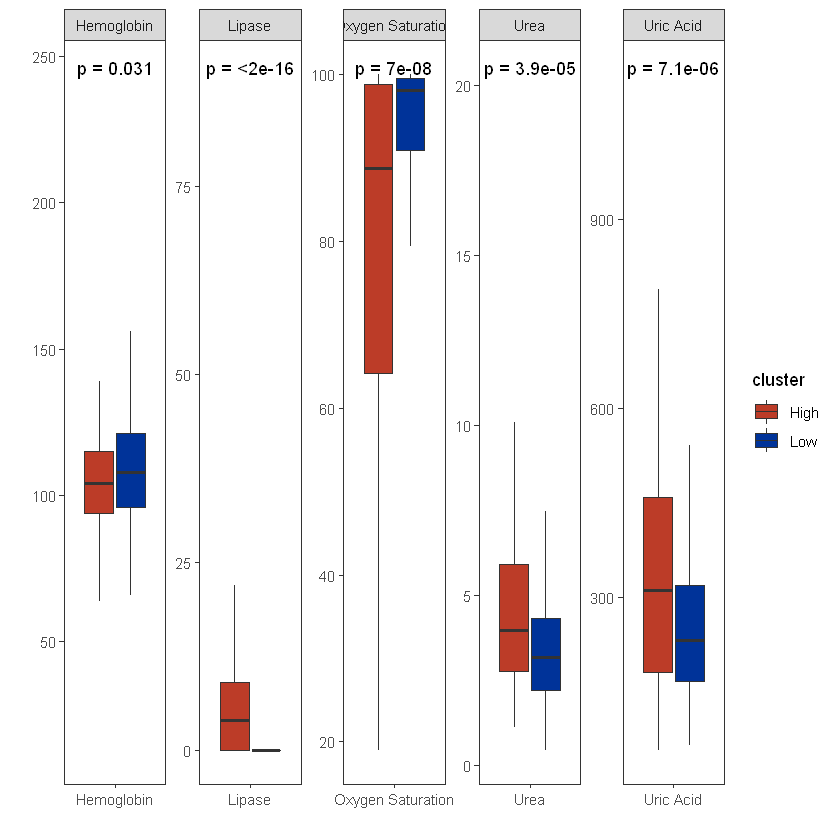

In [19]:
# 5 markers
marker_traindata<-data.frame(marker=rep(c("Uric Acid","Urea","Oxygen Saturation","Hemoglobin","Lipase"),each=nrow(train)),
                             value=c(train$X5083.Uric.Acid..Urine,train$X5033.Urea,train$X5252.Oxygen.Saturation,
                                     train$X5099.Hemoglobin,train$X6473.Lipase),
                             cluster=as.factor(rep(train$fenzu,5))) 
summary(marker_traindata)
a3<-ggplot(marker_traindata, aes(x=marker, y=value, fill=cluster)) + 
    stat_compare_means(label = "p.format",method = "wilcox.test")+
    geom_boxplot(outlier.shape = NA) +
    scale_fill_manual(values = c("#BC3C28","#003399"))+
    xlab("")+ylab("")+
    facet_wrap(~marker, scale="free",nrow=1)+
    theme_bw() + theme(panel.grid=element_blank())
a3

## Test cohort
### KM

Call:
survdiff(formula = Surv(test$Time, test$survival) ~ test$fenzu, 
    data = test)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
test$fenzu=High 32       16     4.45     29.96      39.6
test$fenzu=Low  94        3    14.55      9.17      39.6

 Chisq= 39.6  on 1 degrees of freedom, p= 3e-10 

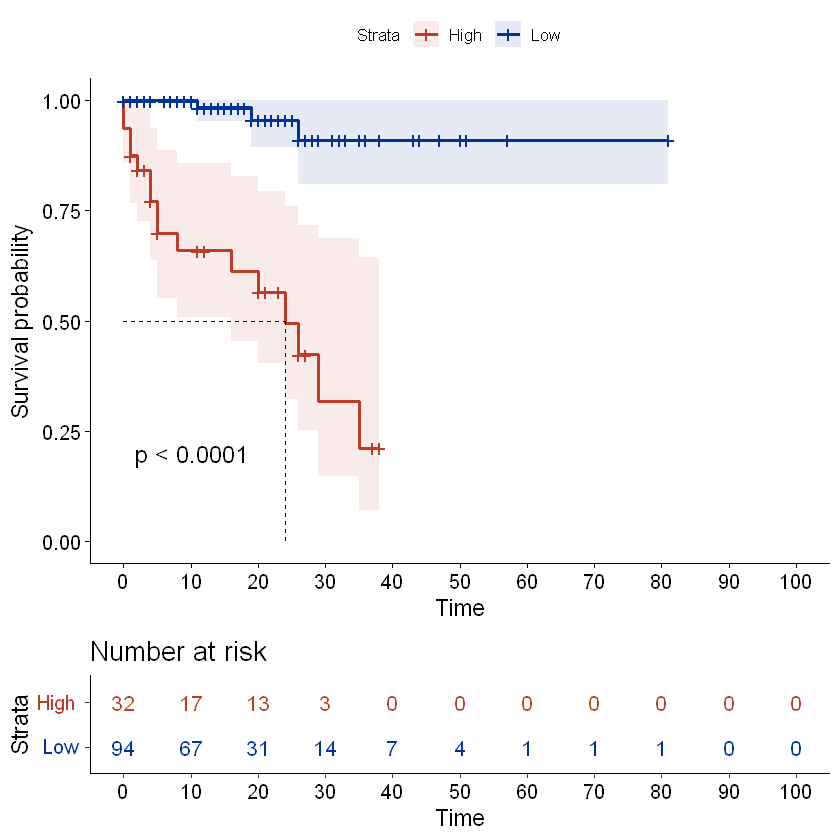

In [20]:
test$fenzu<-NA
test$fenzu[which(test_pred>0.206)]<-"High"
test$fenzu[which(test_pred<=0.206)]<-"Low"
test_surv <- survfit(Surv(test$Time,test$survival)~test$fenzu,data = test)
survdiff(Surv(test$Time,test$survival)~test$fenzu,data = test)
blue <- "#003399"
red <- "#BC3C28"
ggsurvplot(test_surv,
           pval = TRUE,#P-value
           risk.table = TRUE, # Add risk table
           risk.table.col = "strata", # Change risk table color by groups
           palette = c(red,blue),
           conf.int = T,
           conf.int.alpha=0.1, 
           surv.median.line = "hv", 
           xlim=c(0,100),
           break.x.by = 10,
           legend.labs=c("High","Low")
)

In [21]:
# HR
summary(coxph(Surv(test$Time,test$survival) ~ test_pred)) #130.4[17.35,979.9]

Call:
coxph(formula = Surv(test$Time, test$survival) ~ test_pred)

  n= 126, number of events= 19 

             coef exp(coef) se(coef)     z Pr(>|z|)    
test_pred   4.871   130.403    1.029 4.733 2.21e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

          exp(coef) exp(-coef) lower .95 upper .95
test_pred     130.4   0.007669     17.35     979.9

Concordance= 0.87  (se = 0.028 )
Likelihood ratio test= 18.09  on 1 df,   p=2e-05
Wald test            = 22.4  on 1 df,   p=2e-06
Score (logrank) test = 30.26  on 1 df,   p=4e-08


### heatmap

   Risk    Survival
 High:32   0:107   
 Low :94   1: 19   

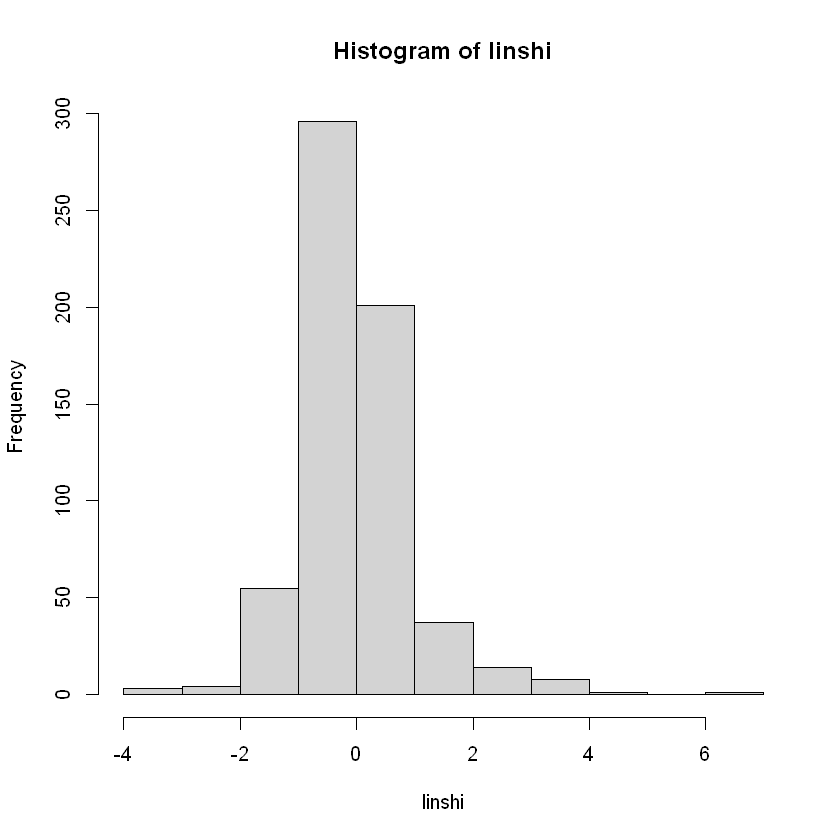

In [22]:
test$score=test_pred
heat_cli=test[,c(8,1)]#risk and sur
heat_cli<-heat_cli[order(test$score),]
heat_exp=test[,c(3:7)]
heat_exp<-heat_exp[order(test$score),]
annotation_col = data.frame(Risk=as.factor(heat_cli[,1]),
                            Survival=as.factor(heat_cli[,2]))
summary(annotation_col)
rownames(annotation_col) <- rep(1:nrow(test))

linshi <- scale(heat_exp[,1:5])#归一化
rownames(linshi) <- rep(1:nrow(test))
linshi<-t(linshi)
hist(linshi)

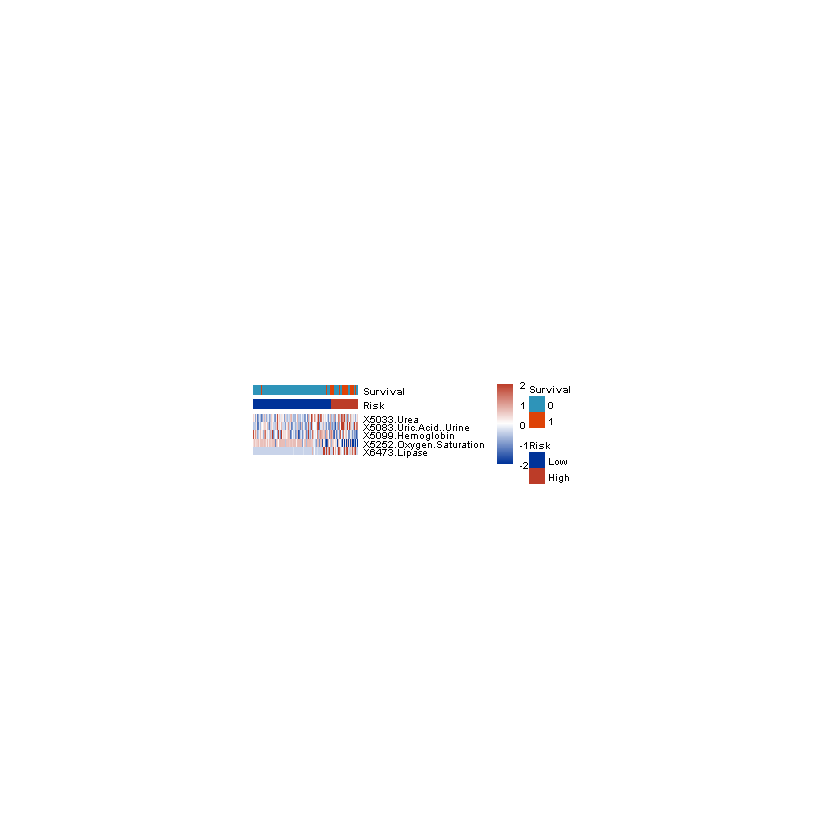

png 
  2

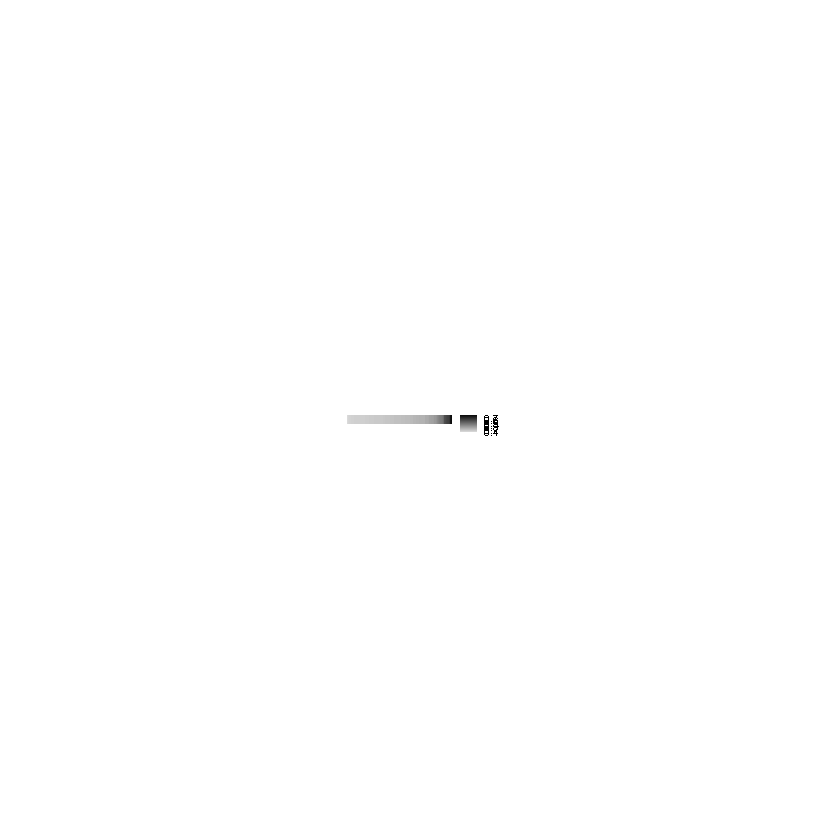

In [23]:
linshi[linshi>2] <- 2
linshi[linshi<(-2)] <- c(-2)
p3<-pheatmap(linshi,fontsize=6,cutree_col = 4,cellheight = 5,cellwidth = 0.5,
             color  = colorRampPalette(c(blue,white,red))(100),
             annotation_col = annotation_col,
             annotation_colors = ann_colors,
             clustering_method = "ward.D2",
             border_color = "grey60",
             cluster_cols = F, cluster_rows = F,
             show_rownames = T, show_colnames = F
)
p3
score=test$score[order(test$score)]
score<-t(score)
p4<-pheatmap(score,fontsize=6,cutree_col = 4,cellheight = 5,cellwidth =0.5,
             color  = colorRampPalette(c("#dadada","#0B0B0B"))(100),
             clustering_method = "ward.D2",
             border_color = "grey60",
             cluster_cols = F, cluster_rows = F,
             show_rownames = T, show_colnames = T
)
p4
p_test<- plot_grid(p4$gtable,p3$gtable, nrow = 2, align = "v")
pdf("./Figs/3. heatmapTest.pdf")
p_test
dev.off()

### boxplot: compare high and low group

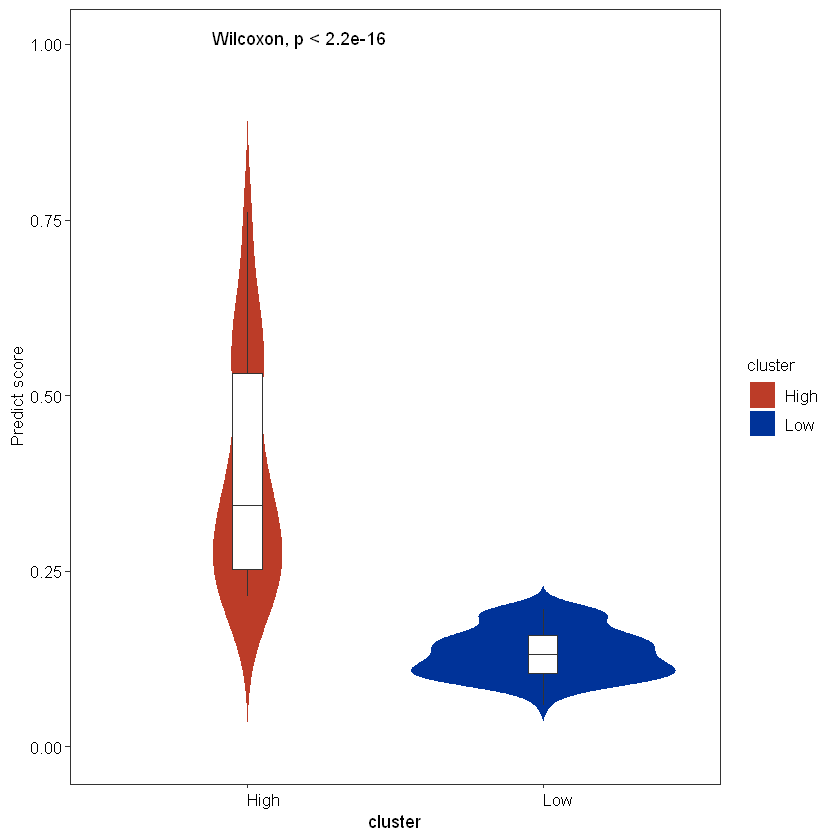

In [24]:
# all
data3 <- data.frame(score = test_pred, 
                    cluster = as.factor(test$fenzu)) 
a4<-ggplot(data = data3, aes(x = cluster , y = score,fill=cluster)) + 
  stat_compare_means(label.y = 1, label.x = 1)  +  
  geom_violin(trim=F,color="white",width = 0.9) +
  geom_boxplot(outlier.size=NA, size=0.01, outlier.shape = NA,width = 0.1,fill = "#FFFFFF")+ 
  scale_fill_manual(values = c("#BC3C28","#003399"))+ 
  theme_bw()+ 
  theme(axis.text.x=element_text(hjust = 0,colour="black",size=10), 
        axis.text.y=element_text(size=10,colour="black"), 
        axis.title.y=element_text(size = 10,colour="black"), 
        legend.text=element_text(colour="black",  
                                 size=10),
        legend.title=element_text(colour="black", 
                                  size=10),
        panel.grid.major = element_blank(),   
        panel.grid.minor = element_blank())+ 
  ylab("Predict score")
a4

Warning message:
"Removed 10 rows containing non-finite values (stat_compare_means)."
Warning message:
"Removed 10 rows containing non-finite values (stat_boxplot)."


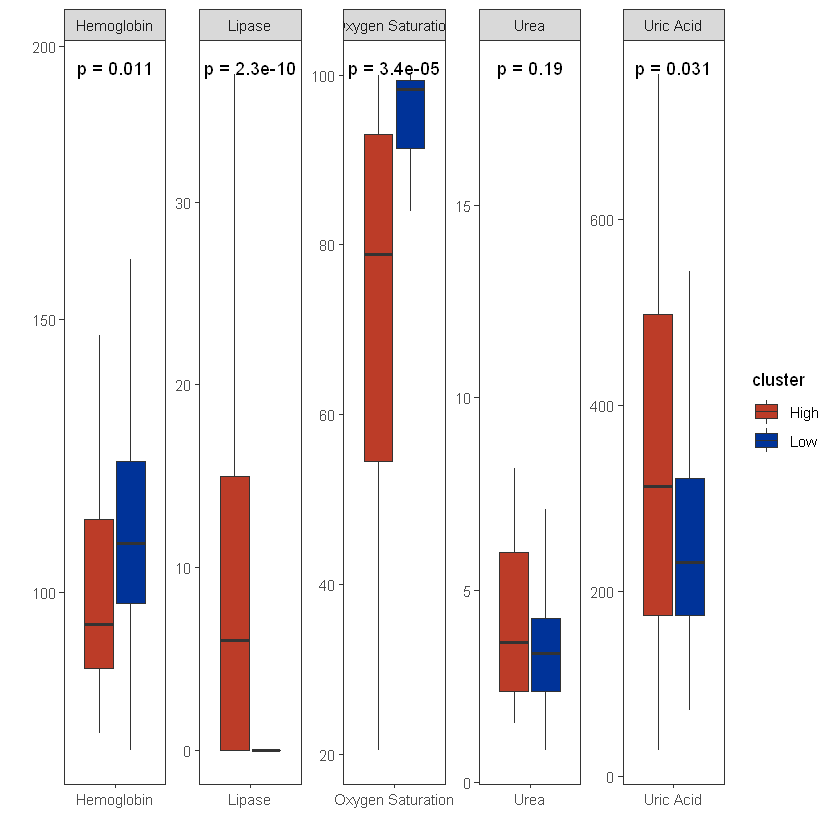

In [25]:
#----boxplot compare High and Low risk 5 markers--#
marker_testdata<-data.frame(marker=rep(c("Uric Acid","Urea","Oxygen Saturation","Hemoglobin","Lipase"),each=nrow(test)),
                             value=c(test$X5083.Uric.Acid..Urine,test$X5033.Urea,test$X5252.Oxygen.Saturation,
                                     test$X5099.Hemoglobin,test$X6473.Lipase),
                             cluster=as.factor(rep(test$fenzu,5))) 
a5<-ggplot(marker_testdata, aes(x=marker, y=value, fill=cluster)) + 
  stat_compare_means(label = "p.format",method = "wilcox.test")+
  geom_boxplot(outlier.shape = NA) +
  scale_fill_manual(values = c("#BC3C28","#003399"))+
  xlab("")+ylab("")+
  facet_wrap(~marker, scale="free",nrow=1)+
  theme_bw() + theme(panel.grid=element_blank())
a5

### s. patients aged 3-5 validata

In [8]:
data5 <- read.csv("./Temps/s.model_Data_3_5.csv",stringsAsFactors = F)
head(data5,2)

,SUBJECT_ID,HADM_ID,ADMI_AGE,GENDER,Time,EXPIRE_FLAG,X5033.Urea,X5083.Uric.Acid..Urine,X5099.Hemoglobin,X5252.Oxygen.Saturation,X6473.Lipase
,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,676,100662,1129,M,12,0,3.10,124.0,97,96.6,12
2,836,100816,1162,M,3,0,3.29,219.5,137,100.0,5


In [9]:
vdata5 <- as.matrix(data5[,7:11])
pred <- predict(mxgb5m,vdata5,type = "response")
roc(data5$EXPIRE_FLAG,pred)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = data5$EXPIRE_FLAG, predictor = pred)

Data: pred in 42 controls (data5$EXPIRE_FLAG 0) < 1 cases (data5$EXPIRE_FLAG 1).
Area under the curve: 0.881

In [13]:
pred[which(data5$EXPIRE_FLAG==1)]

[1] 0.2492432


 0  1 
42  1 

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
"Median survival not reached."


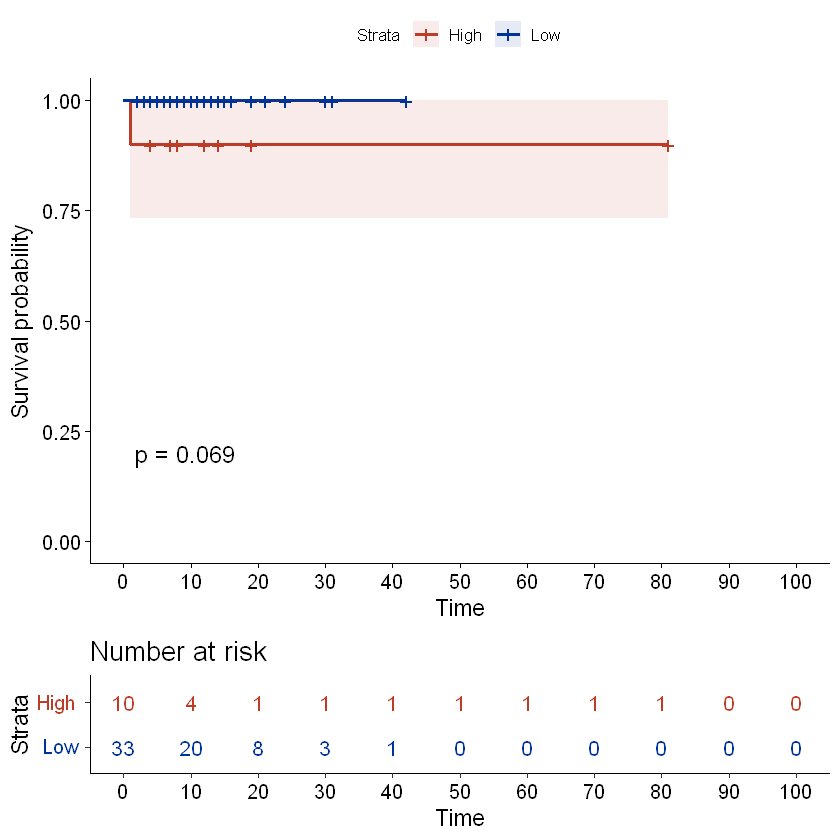

In [16]:
table(data5$EXPIRE_FLAG)
data5$fenzu<-NA
data5$fenzu[which(pred>0.206)]<-"High"
data5$fenzu[which(pred<=0.206)]<-"Low"
blue <- "#003399"
red <- "#BC3C28"
data5_surv <- survfit(Surv(data5$Time,data5$EXPIRE_FLAG)~data5$fenzu,data = data5)
ggsurvplot(data5_surv,
           pval = TRUE,#P-value
           risk.table = TRUE, # Add risk table
           risk.table.col = "strata", # Change risk table color by groups
           palette = c(red,blue),
           conf.int = T,
           conf.int.alpha=0.1, #CI
           surv.median.line = "hv", # median survival time
           xlim=c(0,100),
           break.x.by = 10,
           legend.labs=c("High","Low")
)